# Import Required Libraries
Import the necessary libraries, including scipy.io for reading MATLAB files.

In [59]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [60]:
# Importing the required library
import scipy.io as sio
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define the constants for the Dataset:

In [61]:
SAMPLE_DURATION = 64
INTENSIFIED_N_TIMES = 20
LEVELS = 6 # in this case, rows == Columns == 6
N_CHARACTERS = 36

# Define the Function to Load MATLAB Files
Define a function that uses scipy.io.loadmat() to load a MATLAB file and return the data.

In [62]:
def load_matlab_file(file_path):
    data = sio.loadmat(file_path)
    
    return data

# Read the MATLAB Files
Use the defined function to load data from a series of MATLAB files.

In [63]:
# List of MATLAB files
matlab_files = os.listdir('data/raw')

# Initialize an empty dictionary to store the data from all files
all_data = {}

# Loop through each file
for file in matlab_files:
    # Load the data from the file using the function defined above
    raw_data = load_matlab_file(f"data/raw/{file}")['data'][0]
    eeg_data = raw_data['X'][0] # Shape  (347704, 8)
    print(eeg_data.shape)
    stimulus_type = raw_data['y'][0]  # Shape (347704, 1)
    stimulus_class = raw_data['y_stim'][0] # Shape (347704, 1)
    # trial_start_indices = data['trial'][0][0] # Shape (35, 1)
    
    # Create a DataFrame with eeg_data, stimulus_type, and stimulus_class
    data = pd.DataFrame(eeg_data, columns=[f'ch_{i}' for i in range(1, 9)])
    data['stimulus_type'] = stimulus_type
    data['stimulus_class'] = stimulus_class

    # Now we filter the data to only include the rows where the stimulus_type is 1 or 2
    data = data[data['stimulus_type'].isin([1, 2])]

    # Store the data in the dictionary
    all_data[file] = data

all_data['A01.mat'].shape

(347704, 8)
(347704, 8)
(347704, 8)
(347704, 8)
(347704, 8)
(347704, 8)
(347704, 8)
(347704, 8)


(134400, 10)

# Conver the matlab matrices to numpy arrays

And then create a DataFrame with the data.

In [64]:
def save_data(filename, data):
    np.save(filename, data)

In [65]:
"""
Trial info:
(64 x 20 = 1280) samples per trial
(samples_per_stimuli x n_stimuli x n_characters)
"""
def transform_data(data: list, subject: int, samples_per_target, sample_offset: int = 0):
    eeg_data = data['X'][0]
    stimulus_type = data['y'][0]
    trial_start_indices = data['trial'][0][0]

# Sample duration: 64 x n_intensification x (n_intensification_points x n_dimmension)
# (64 * 10 * 6 * 2)
    samples_x_trial = SAMPLE_DURATION * INTENSIFIED_N_TIMES * LEVELS  # (64 * 10 * 6 * 2) = 7680
    final_data_class1 = np.zeros((samples_per_target,  # number of samples to take into account per trial (depends on the input -PARAM-)
                           samples_x_trial,  # number of samples per trial (constant)
                           8)) # number of channels

    final_data_class2 = final_data_class1.copy()

    class_1 = 0
    class_2 = 0

    # (#n_trial, #channels, #time, #depth)
    for i, start_idx in enumerate(trial_start_indices):
        end_idx = start_idx + samples_x_trial + (256) # 256 samples of padding
        trial_data = eeg_data[(start_idx + sample_offset):(end_idx + sample_offset)]
        trial_stimulus_type = stimulus_type[(start_idx + sample_offset):(end_idx + sample_offset)]


        # Reshape the trial data to have the shape (64,   20 * 36,                , 8)
        trial_data_ = trial_data # .reshape((SAMPLE_DURATION * INTENSIFIED_N_TIMES, 8))
        trial_stimulus_type_ = trial_stimulus_type # .reshape((SAMPLE_DURATION, INTENSIFIED_N_TIMES, 1))

        # Loop through each observation in the trial
        for j in range(INTENSIFIED_N_TIMES * LEVELS):
            # Get the stimulus type
            stimulus_type_ = trial_stimulus_type_[j * 64 : (j + 1) * 64 - 1]
            # Get the data for the character
            character_data = trial_data_[(j * 64) : ((j * 64) +  256), :]

            # Check if the stimulus type is 1 (not target) or 2 (target)
            if 1 in stimulus_type_:
                # Append the data to the final_data array
                final_data_class1[:, class_1] = character_data
                class_1 += 1
            elif 2 in stimulus_type_:
                # Append the data to the final_data array
                final_data_class2[:, class_2] = character_data
                class_2 += 1
            else:
                raise ValueError("Invalid stimulus type")


        # Delete all zeros
    final_data_class1_ = final_data_class1[:, :class_1]
    final_data_class2_ = final_data_class2[:, :class_2]
    print (f"Class 1: {class_1}, Class 2: {class_2}")
    return final_data_class1_, final_data_class2_


In [66]:
"""
Data set
X=[samples X Channels]
Y=[StimType X 1] ( 1 = NonTarget stimulus, 2 = Target Stimulus)
Y_stim= [StimClass X 1] intensified stimulus classes (Figure 2)
Trial=[Trials X 1] trial start in samples
Classes = textual description of conditions related to Y
Classes_stim = textual description of conditions related to Y_stim
"""
files = ["A01.mat","A02.mat","A03.mat","A04.mat","A05.mat","A06.mat","A07.mat","A08.mat"]


# Create directories for classes 0 and 1
# os.mkdir('./data/partitioned')
os.makedirs('./data/partitioned/class_1', exist_ok=True)
os.makedirs('./data/partitioned/class_2', exist_ok=True)

for file in files:
    matlab_data = load_matlab_file(f"data/raw/{file}")['data'][0]
    fd_c1, fd_c2 = transform_data(matlab_data, file.replace('.mat', ''), 256)
    print(f"File: {file}") # (2, 32, 700, 8) 700 is because 35 * 20 (35 chars * 20 intensitifacted per char)

    # The data should be inbalanced (class 2 is lower than class 1 on axis 1)
    assert fd_c1.shape[1] > fd_c2.shape[1]

    # Now, save the data to the respective directories
    save_data(f'./data/partitioned/class_1/{file.replace(".mat", "")}', fd_c1)
    save_data(f'./data/partitioned/class_2/{file.replace(".mat", "")}', fd_c2)

Class 1: 3500, Class 2: 700
File: A01.mat
Class 1: 3500, Class 2: 700
File: A02.mat
Class 1: 3500, Class 2: 700
File: A03.mat
Class 1: 3500, Class 2: 700
File: A04.mat
Class 1: 3500, Class 2: 700
File: A05.mat
Class 1: 3500, Class 2: 700
File: A06.mat
Class 1: 3500, Class 2: 700
File: A07.mat
Class 1: 3500, Class 2: 700
File: A08.mat


In [67]:
labels = matlab_data['y'].all().flatten()
start_idxs = matlab_data['trial']

In [68]:
idxs = start_idxs.all().flatten()
idxs

array([  1801,  11529,  21257,  30985,  40713,  51473,  61201,  70929,
        80657,  90385, 101145, 110873, 120601, 130329, 140057, 150817,
       160545, 170273, 180001, 189729, 200489, 210217, 219945, 229673,
       239401, 250161, 259889, 269617, 279345, 289073, 299833, 309561,
       319289, 329017, 338745], dtype=int32)

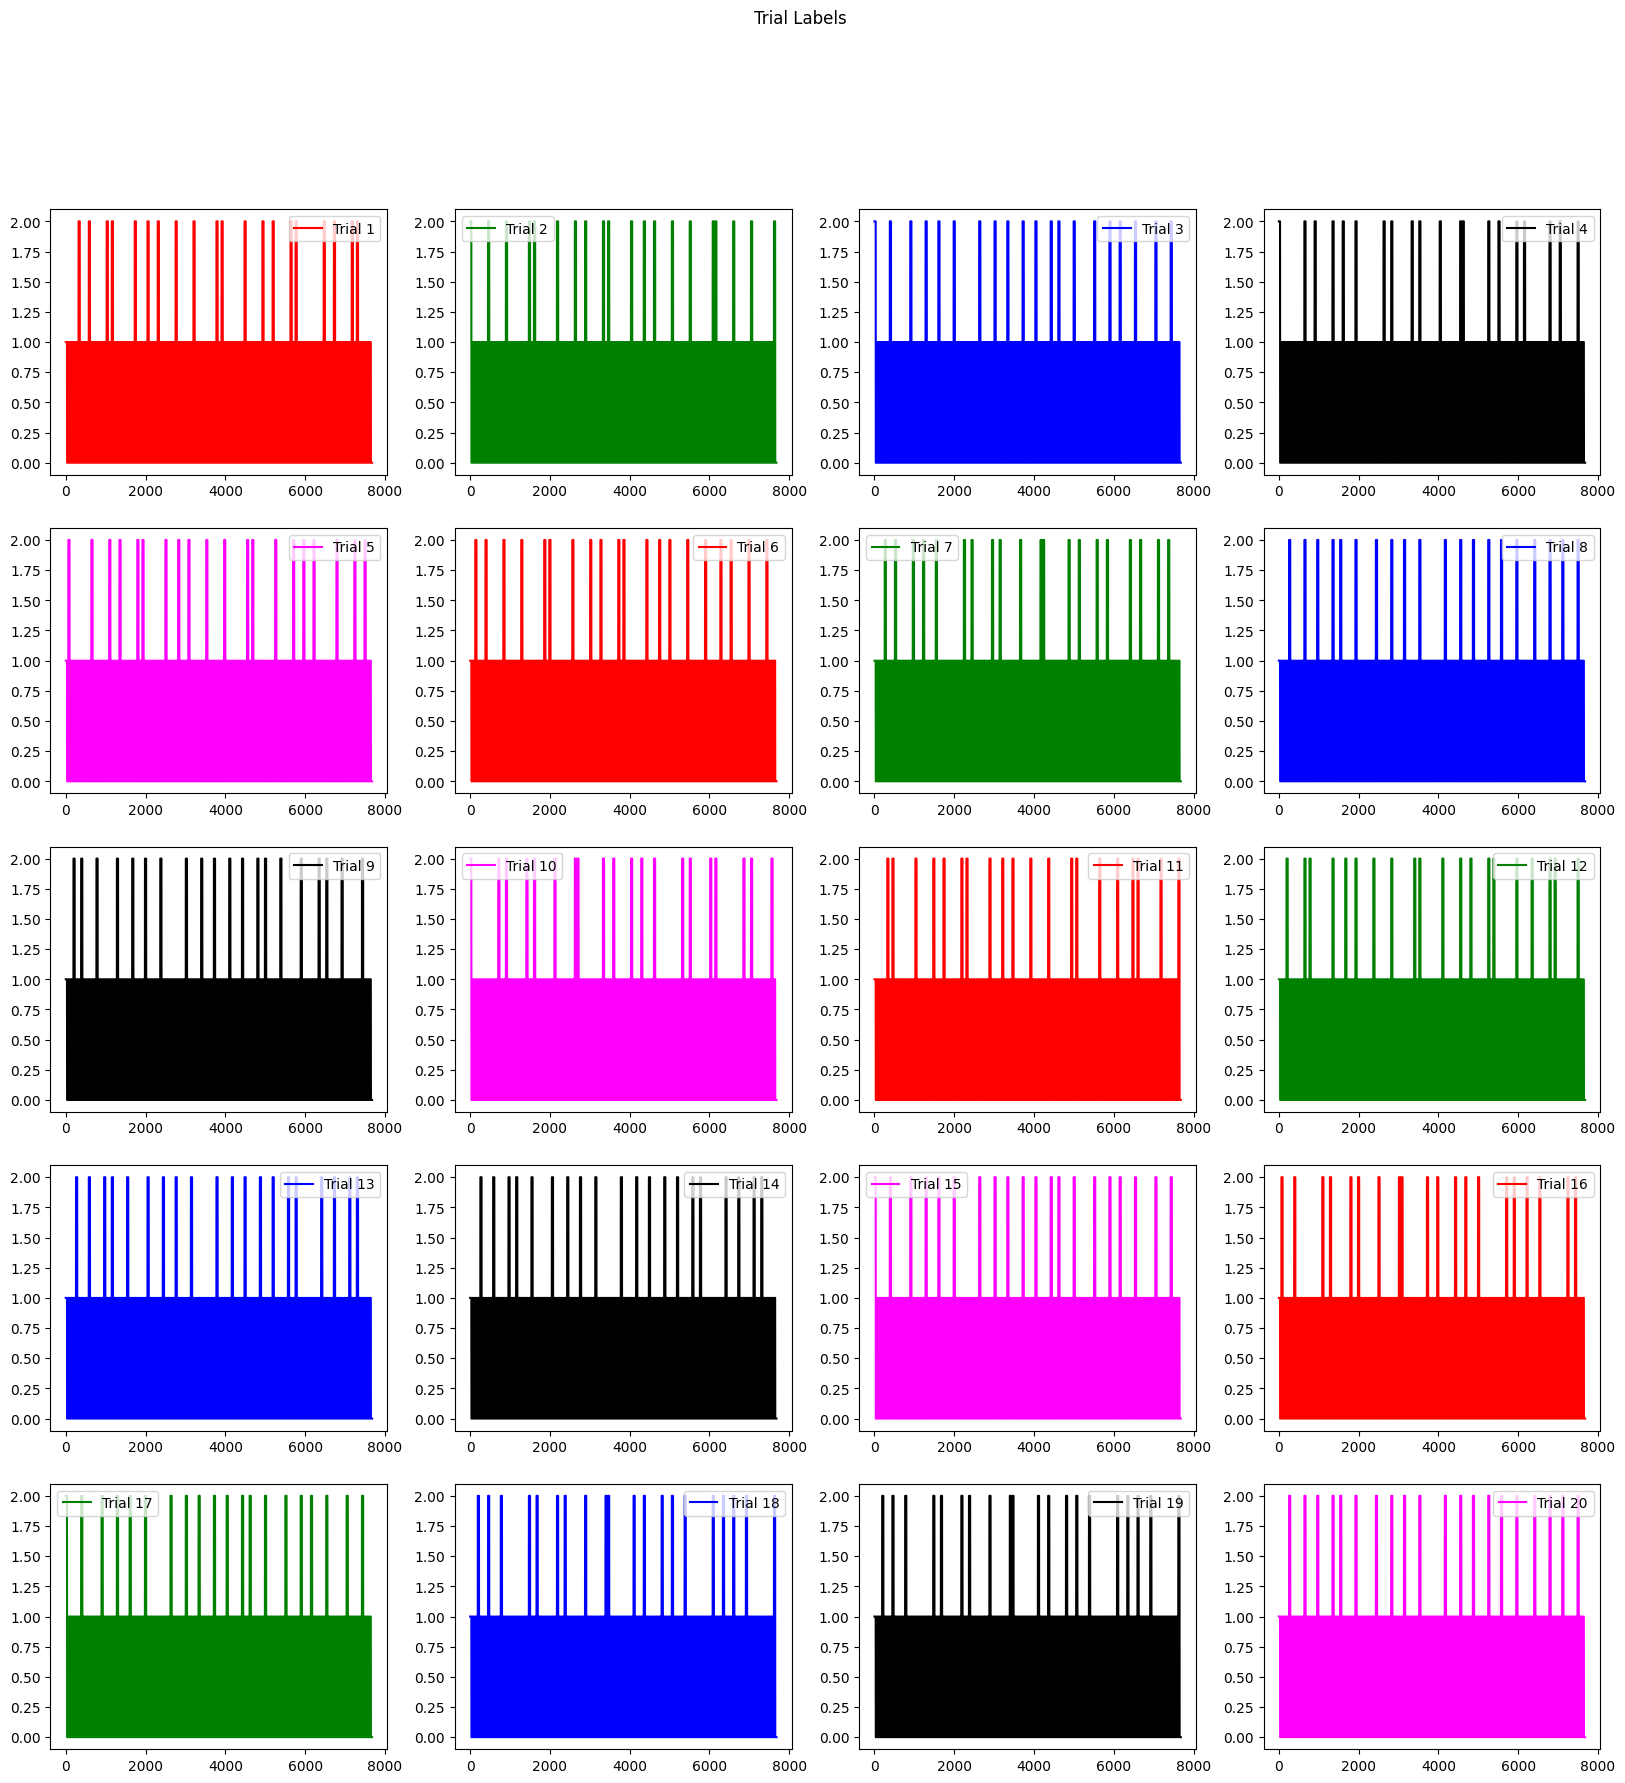

In [69]:
# Now plot all the trial labels on different plots
fig, axs = plt.subplots(5, 4, figsize=(20, 20))
fig.suptitle('Trial Labels')

cols = ['red', 'green', 'blue', 'black', 'magenta']

for i, ax in enumerate(axs.flat):
    start_idx = idxs.take(i)#  - (200 if i > 0 else 0)
    end_idx = start_idx + (64 * 10 * 6 * 2)
    ax.plot(labels[start_idx:end_idx], label=f'Trial {i+1}', color=cols[i % len(cols)])
    ax.axvspan(end_idx-400, end_idx-200, color='cyan', alpha=0.9)  # Paint the last 200 time points with CYAN
    ax.legend()
plt.show()